In [ ]:
# default_exp models


# models
> models to be used in contextual map solvers

In [ ]:
#export
from thompson_sampling.multi_armed_bandits import contextual_categorical_bandit, contextual_categorical_get_optimal_arm
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
%matplotlib inline


In [ ]:
theta = [0.6, 0.9]
noise = 0.1

np.random.seed(42)

## Categorical
> for logistic regression

### Linear

In [ ]:
#export
from scipy.optimize import minimize
import scipy.stats as stats
import numpy as np



class OnlineLogisticRegression:
    """taken from https://gdmarmerola.github.io/ts-for-contextual-bandits/ """
    
    # initializing
    def __init__(self,n_dim, lambda_ = None, alpha = None):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_ or 1
        self.alpha = alpha or 1
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
      return stats.multivariate_normal(self.m, self.alpha * (self.q)**(-1.0)).rvs()
        #return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)


    def observe(self,X,y):
      self.fit(X,y)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')


        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

No handles with labels found to put in legend.


<Figure size 1350x525 with 0 Axes>

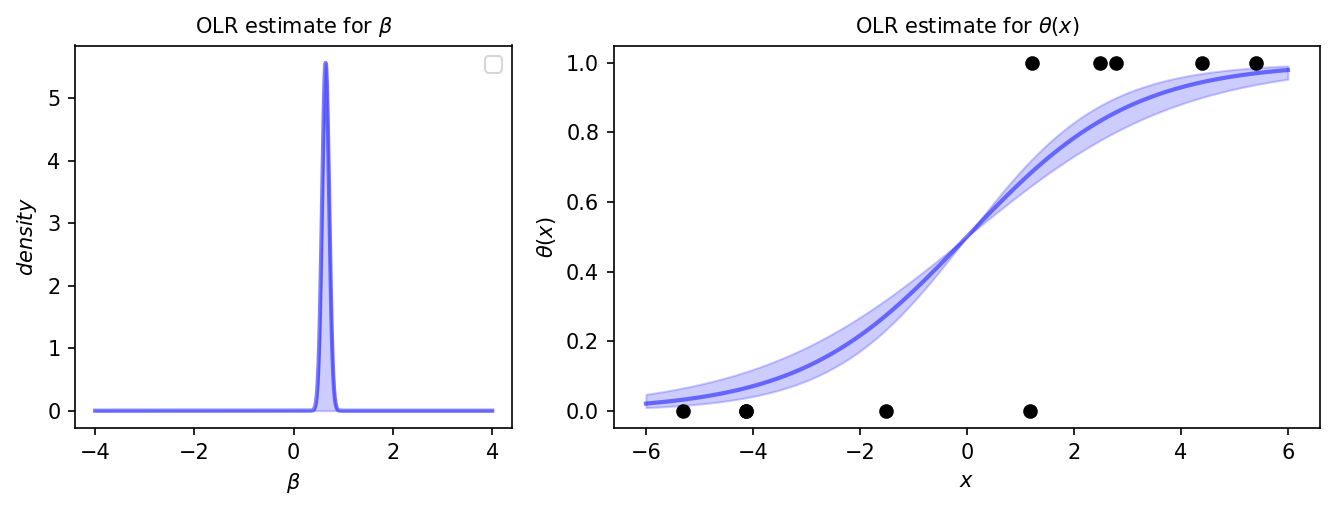

In [ ]:


wee_x = np.random.uniform(-6,6,10)
wee_y = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr = OnlineLogisticRegression(1, .5, 1)
for i in range(len(wee_y)):
    online_lr.fit(wee_x[i].reshape(-1,1), wee_y[i].reshape(-1,1))
    
    
    
    
    
# closing other figures
plt.close('all')
plt.figure(figsize=[9,3.5], dpi=150)

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = stats.norm(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
#ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(wee_x, wee_y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

## numerical
> for regression


### Linear

In [ ]:
#export

"this is not working at the moment"
class BayesLinReg(object):

  def __init__(self, num_features,v):
    self.intercept = False
    if self.intercept:
      num_features += 1

    self.B = np.eye(num_features)
    self.Binv = np.linalg.inv(self.B)
    self.f = np.atleast_2d(np.zeros(num_features))
    self.v = v

    self.mu = np.zeros(num_features)

  def add_intercept(self,X):
    if self.intercept:
      X = np.insert(np.atleast_2d(X),0,1)
    X = np.atleast_2d(X)
    
    return X.T


  def observe(self,X,y):
    y = np.atleast_2d(y)
    X = self.add_intercept(X)
    self.B += np.outer(X,X)
    self.f += np.dot(X,y).T


  def get_mean_std(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)

      return mu_t, B_inv

      

#helpers
  def train(self,X,y,shuffle = True):
      index = list(range(X.shape[0]))
      if shuffle ==True:
          np.random.shuffle(index)
      for i in index:
          self.observe(X[i],y[i]) 
          

      
  def predict_ML(self,X):
      beta= np.linalg.inv(self.B).dot(self.f.T)

      y = []
      try:
          for i in range(len(X)):
              x = X[i]
              y += [self.predict_ML_x(x)]
              return y
      except:
          X = self.add_intercept(X)
          return X.T.dot(beta)
          




  def predict_ML_x(self,x):
      beta = np.linalg.inv(self.B).dot(self.f.T)
      x = self.add_intercept(x)
      return x.T.dot(beta)[0][0]

  def draw(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)
      dist = stats.multivariate_normal
      return dist.rvs(mean=mu_t.flatten(),cov=self.v**2*B_inv)


### nonlinear

In [ ]:
#export 
import torch
from torch.autograd import Variable

class SimpleModel(torch.nn.Module):
    def __init__(self,num_input, num_hidden_units=100, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(num_input,num_hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_units,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [ ]:
X = np.atleast_2d(np.linspace(-3,3,100)).T

y = np.sin(X) + np.random.normal(1)

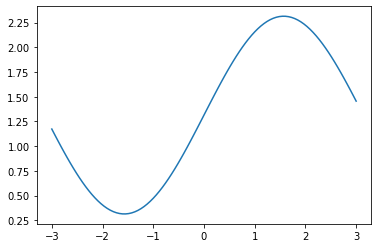

In [ ]:
plt.plot(X,y)

In [ ]:
sm = SimpleModel(1)

In [ ]:
y_hat = sm(X)

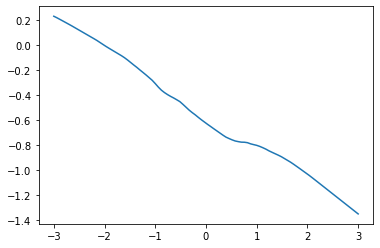

In [ ]:
plt.plot(X,y_hat.detach())

In [ ]:
epochs = 10000

optimizer = torch.optim.SGD(
            sm.parameters(),
            weight_decay=0.01,
            lr=0.001)
criterion = torch.nn.MSELoss()
y = Variable(torch.Tensor(y), requires_grad=False)

for i in range(epochs):
    y_pred = sm(X)
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

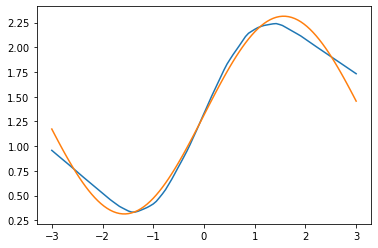

In [ ]:
y_hat = sm(X)
plt.plot(X,y_hat.detach())
plt.plot(X,y)